# NAIVE FORECASTING 

In [3]:
import pandas as pd 
import math
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import metrics
plt.style.use('fivethirtyeight')

In [5]:
# In order to use this notebook for univarate time series analysis :-
# 1) The primary requirement is not to have missing values or categorial(string) data for time_dependent variable 
#    and time_column.
# 2) This cell requires information on file_name (only csv), time_dependent_variable, time_column, date_time format (frmt)
#    and resample grain(X). After filling the required information correctly, you can run all the cells (Cell ---> Run All)
# 3) Example :-
#   file_name               = "JetRail Avg Hourly Traffic Data - 2012-2013.csv"
#   time_dependent_variable = "Count"    (column name in your dataset)
#   time_column             = "Datetime" (column name in your dataset)
#   frmt                    = "%Y-%m-%d"
#   X                       = "D" 

file_name = "cta_ridership.csv"
time_dependent_variable = "total_rides"
time_column = "service_date"
frmt =  '%Y-%m-%d'
X = "D"

### Reading the csv file

In [6]:
def data(time_column, file_name, frmt='%Y-%m-%d %H:%M:%S', X= "D"):
    df = pd.read_csv(file_name, parse_dates= True)
    df = df[[time_column,time_dependent_variable]]
    df[time_column] = pd.to_datetime(df[time_column],format=frmt) 
    df.index = df[time_column]
    df = df.resample(X).mean()
    df.reset_index(inplace= True)
    return df
df = data(time_column, file_name, frmt, X)

In [7]:
df.head()

,service_date,total_rides
0,2001-01-01,423647.0
1,2001-01-02,1282779.0
2,2001-01-03,1361355.0
3,2001-01-04,1420032.0
4,2001-01-05,1448343.0


### Splitting the data into train and test using (you can use any one of them) :-

In [8]:
# This splits the data into train and test using default split_size = 0.7
def train_test_split_perc(df, split= 0.7):
    total_size=len(df)
    train_size=math.floor(split*total_size) #(70% Dataset)
    train = df.head(train_size)
    test  = df.tail(len(df) - train_size)
    return test,train
    
test,train = train_test_split_perc(df, split= 0.9)

In [9]:
# This splits the data into train and test using split_date
def train_test_split_date(df, split_date):
    split_date = '2017-01-01'
    train = df.loc[df.index <= split_date].copy() 
    test = df.loc[df.index > split_date].copy()
    return train, test

#test,train = train_test_split_date(df,split_date)

### plot function

In [17]:
    def plot(title,prediction,time):
        plt.figure(figsize=(12,8))
        plt.plot(train[time_column], train[time_dependent_variable], label='Train',linewidth=2)
        plt.plot(test[time_column],test[time_dependent_variable], label='Test',linewidth=2)
        plt.plot(time,prediction, label=title,linewidth=1)
        plt.legend(loc='best')
        plt.title(title)
        plt.show()

Evaluation Metrics :-
- Mean squared error (MSE) tells you how close a regression line is to a set of points. It does this by taking the distances
  from the points to the regression line (these distances are the errors) and squaring them. The closer to zero the error is,
  the better the model.
- Mean absolute error (MAE) measures the average magnitude of the errors in a set of predictions, without considering their
  direction. The closer to zero the error is, the better the model.
- Root mean square error (RMSE) is a quadratic scoring rule that also measures the average magnitude of the error. It’s the 
  square root of the average of squared differences between prediction and actual observation. The closer to zero the error is
  ,the better the model.
- Mean absolute percentage error (MAPE) is a statistical measure of how accurate a forecast system is. It is a measure in
  terms of percentage. It is mostly used for time-series forecasting. The closer to zero the error is, the better the model.
- R-squared determines the proportion of variance in the dependent variable that can be explained by the independent variable.

In [11]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

### One-Step Baseline Model : Naive ( Strategy = Last) 

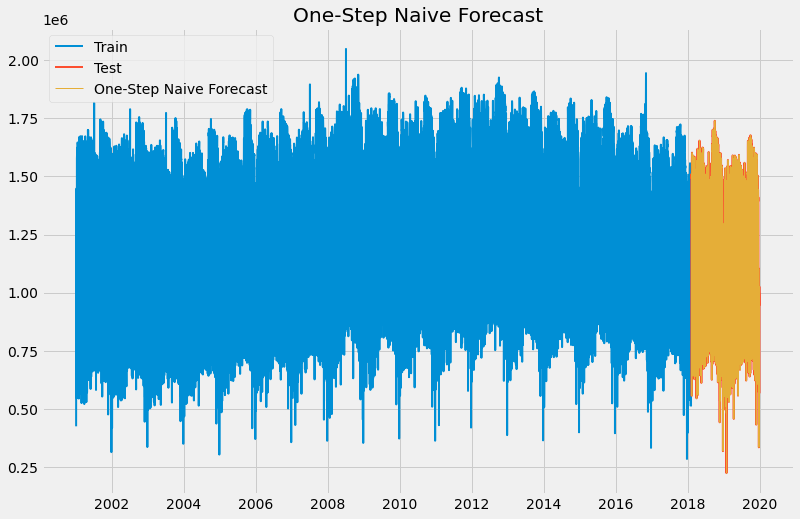

Evaluation metric results:-
MSE is : 165649045865.40692
MAE is : 271641.1991341991
RMSE is : 407000.0563457048
MAPE is : 26.944520837554293
R2 is : -0.19715755359410903



In [22]:
# It is a one-step time series forecasting model. It can be treated as a baseline for one-step forecasting models. 
# y_pred(t) = y(t-1)

def naive_forecaster():
    
    test_df = pd.concat([test,test[time_dependent_variable].shift(1)],axis=1) 
    test_df = test_df.dropna()
    test_df.columns = [time_column,time_dependent_variable,"prediction"]
    
    plot("One-Step Naive Forecast",test_df['prediction'],test_df[time_column])
    return timeseries_evaluation_metrics_func(test_df[time_dependent_variable],test_df["prediction"])
    
naive_forecaster()    

### Multi-Step Baseline Models

##### 1)  Naive Forecasting Model (Strategy = last)

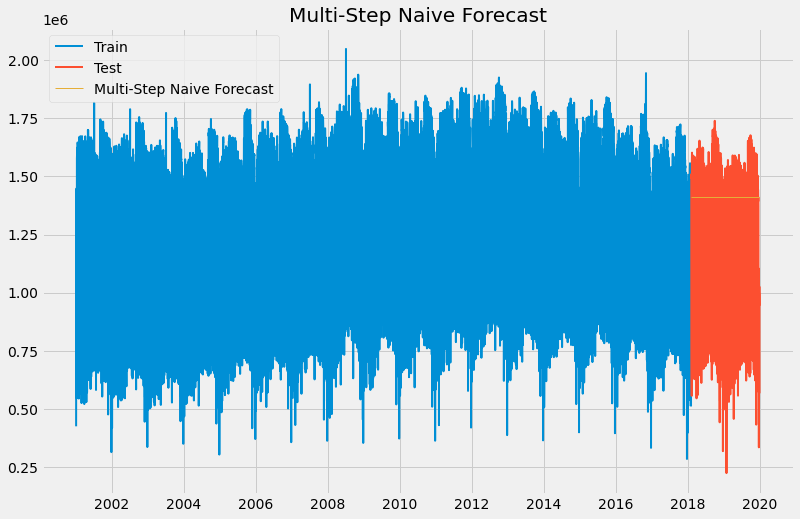

Evaluation metric results:-
MSE is : 157632115095.42218
MAE is : 294684.45389048994
RMSE is : 397029.11114353087
MAPE is : 36.16871177970532
R2 is : -0.14027977600272612



In [23]:
# For naïve forecasts, we simply set all forecasts to be the value of the last observation. This method works remarkably well
# for many economic and financial time series.

# Formula :-
# y_hat(T+h|T) = yT

def naive_forecastor_multiple():
    dd = np.asarray(train[time_dependent_variable])
    lastvalue = dd[len(dd)-1]
    y_hat = test.copy()
    y_hat['naive'] = lastvalue

    plot("Multi-Step Naive Forecast",y_hat['naive'],y_hat[time_column])
    return timeseries_evaluation_metrics_func(test[time_dependent_variable],y_hat.naive)

naive_forecastor_multiple()

#### 2) Simple Average Forecasting Model

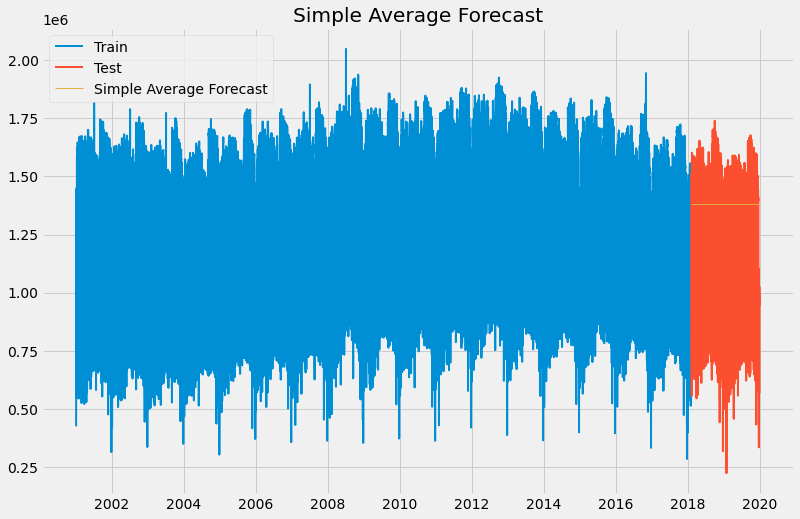

Evaluation metric results:-
MSE is : 150188551900.16507
MAE is : 301285.32223381015
RMSE is : 387541.6776298584
MAPE is : 35.868864526432446
R2 is : -0.08643450108643203



In [26]:
# The forecasts of all future values are equal to the average (or “mean”) of the historical data. It is a useful baseline for 
# multi-step models.

def simple_average():
    y_hat = test.copy()
    y_hat['simple_avg'] = train[time_dependent_variable].mean()

    plot("Simple Average Forecast",y_hat['simple_avg'],y_hat[time_column])
    return timeseries_evaluation_metrics_func(test[time_dependent_variable],y_hat.simple_avg)

simple_average()

#### 3) Drift Method (Extrapolation)

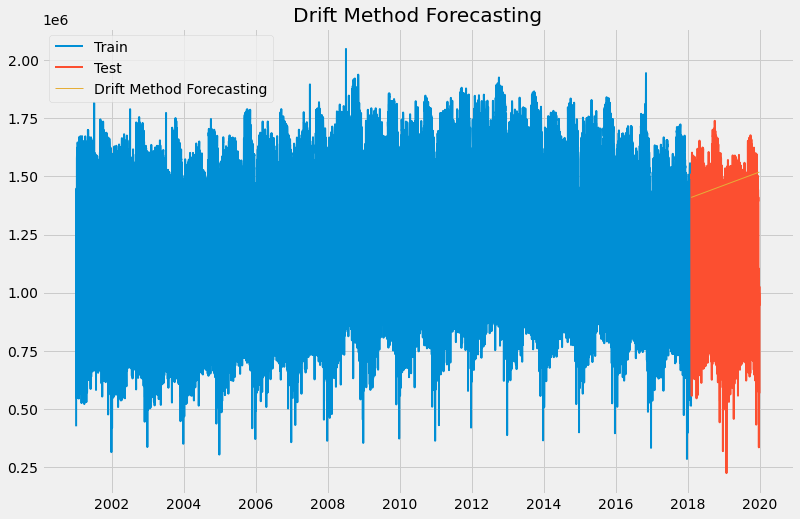

Evaluation metric results:-
MSE is : 178192622725.06238
MAE is : 292193.3291503359
RMSE is : 422128.6802919962
MAPE is : 37.43186755139361
R2 is : -0.28901045198354525



In [27]:
# It can be treated as a baseline for multi-step models.

# Definition :-
# A variation on the naïve method is to allow the forecasts to increase or decrease over time, where the amount of change over
# time (called the drift) is set to be the average change seen in the historical data.

# Formula :-
# y_hat(T+h|T)= y(T)+h(y(T)−y(1)/T−1) where, T is the last value in the train dataset and h is referring to periods in the test 
# data

def drift_method():
    dd = np.asarray(train[time_dependent_variable])
    lastvalue = dd[len(dd)-1]
    firstvalue = dd[0]
    y_hat = test.copy()
    pred = []
    for x in range(1,len(df)-len(dd)+1):
        y = lastvalue + ((lastvalue - firstvalue)/((len(dd)-1)-0))*x
        pred.append(y)
    index = [i for i in range(len(dd),len(df))]    
    pred = pd.Series(pred,index=index)
    y_hat["pred"] = pred
    
    plot('Drift Method Forecasting',y_hat['pred'],y_hat[time_column])
    return timeseries_evaluation_metrics_func(test[time_dependent_variable],y_hat.pred)

drift_method()    